## Hypothesis
We can predict whether a breast tumor is **benign** or **malignant** using measurements of cell nuclei obtained from digitized images of fine needle aspirates (FNA) of breast masses.  
By analyzing features such as radius, texture, perimeter, smoothness, and other characteristics, a machine learning model can identify patterns associated with malignancy and assist in early detection.

## The Data
The dataset contains **569 samples** with **30 numeric features** describing various properties of the cell nuclei, along with a target label indicating diagnosis:  
- **M** = Malignant (cancerous)  
- **B** = Benign (non-cancerous)  

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("breast_cancer_dataset.csv")
df = df.drop(columns=["id"])
df["diagnosis"] = df["diagnosis"].map({"B": 0, "M": 1})
df = df.dropna(axis=1, how='all')

In [2]:
corr = df.corr(numeric_only=True)['diagnosis'].sort_values(ascending=False)
print(corr)

diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

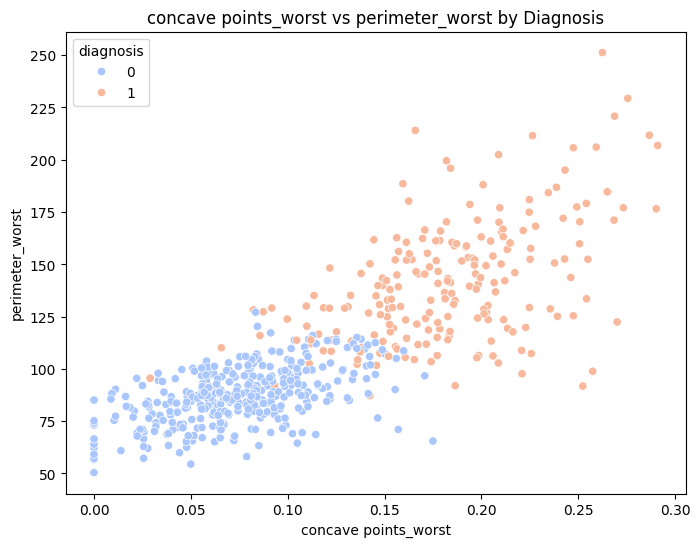

In [3]:
top_features = ['concave points_worst', 'perimeter_worst']

plt.figure(figsize=(8,6))
sns.scatterplot(x=top_features[0], y=top_features[1], 
                hue='diagnosis', palette='coolwarm', data=df)
plt.title(f'{top_features[0]} vs {top_features[1]} by Diagnosis')
plt.show()

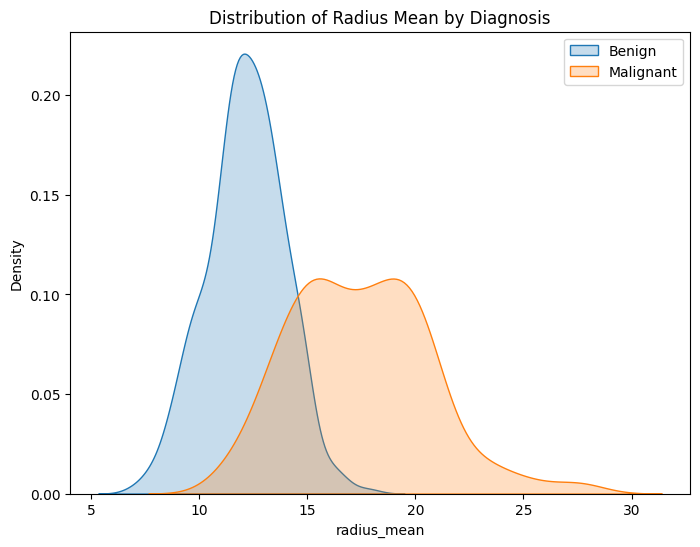

In [4]:
plt.figure(figsize=(8,6))
sns.kdeplot(df[df['diagnosis']==0]['radius_mean'], label='Benign', fill=True)
sns.kdeplot(df[df['diagnosis']==1]['radius_mean'], label='Malignant', fill=True)
plt.title('Distribution of Radius Mean by Diagnosis')
plt.legend()
plt.show()

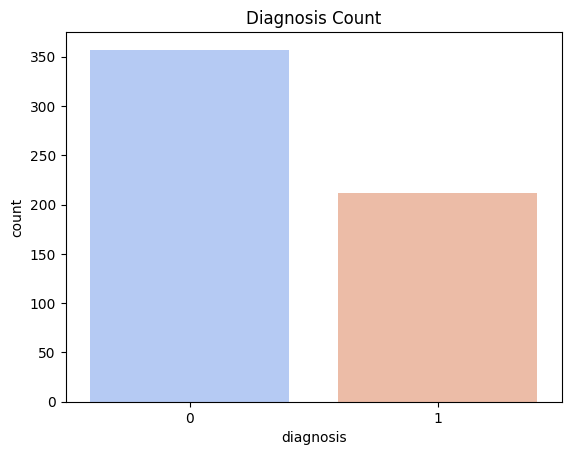

In [5]:
sns.countplot(x='diagnosis', hue='diagnosis', data=df, palette='coolwarm', legend=False)
plt.title('Diagnosis Count')
plt.show()

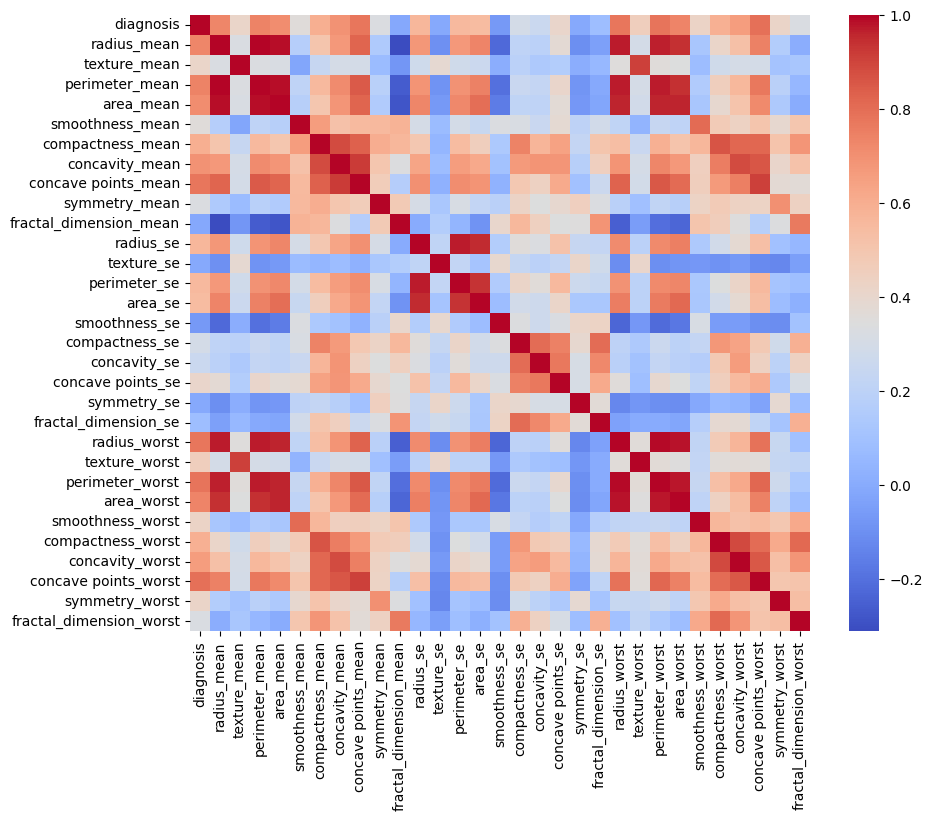

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

## Accuracy Metric
We'll use **accuracy score** as our primary evaluation metric.  
Accuracy measures the proportion of correct predictions (both benign and malignant) out of all predictions made.  

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9649122807017544
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")
print(scores.mean(), scores.std())

0.9633408685451746 0.023992366704972578


In [9]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
import numpy as np

pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_test)[:, 1]

best_t = 0.5
targets = np.linspace(0.2, 0.8, 25)
best_f1 = -1
for t in targets:
    y_hat = (probs >= t).astype(int)
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, y_hat, pos_label=1)
    if f1 > best_f1:
        best_f1, best_t = f1, t

y_opt = (probs >= best_t).astype(int)
print("Chosen threshold:", round(best_t, 3))
print(classification_report(y_test, y_opt))
print(confusion_matrix(y_test, y_opt))


Chosen threshold: 0.25
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

[[71  1]
 [ 1 41]]


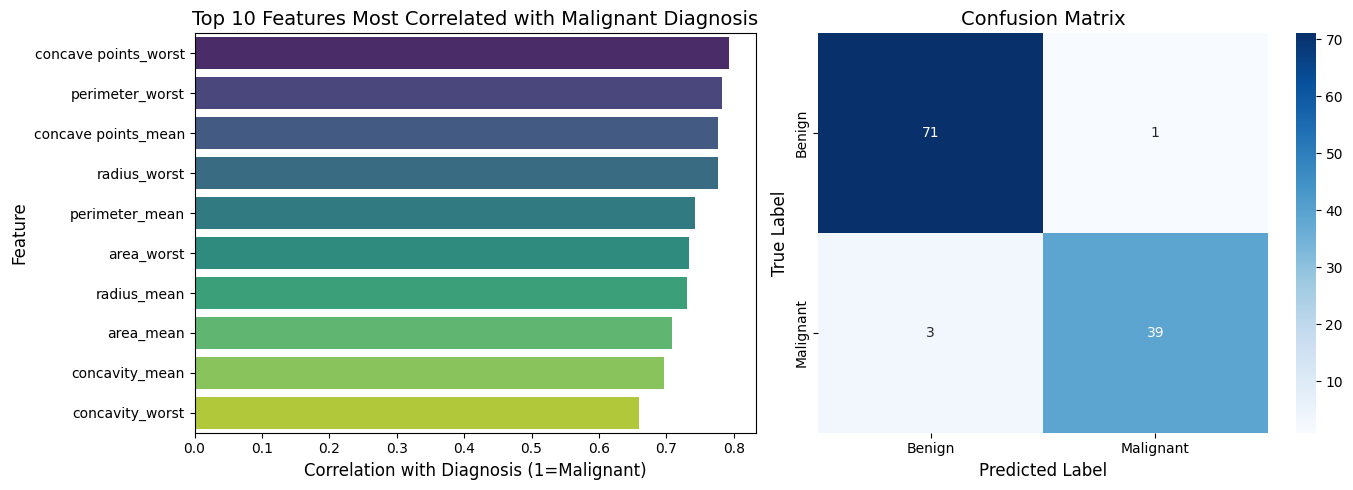

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

corr = df.corr(numeric_only=True)['diagnosis'].sort_values(ascending=False)
top_corr = corr.drop('diagnosis').head(10)

cm = confusion_matrix(y_test, y_pred)
cm_labels = ['Benign', 'Malignant']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot( x=top_corr.values, y=top_corr.index, hue=top_corr.index, palette='viridis', legend=False, ax=axes[0] )
axes[0].set_title('Top 10 Features Most Correlated with Malignant Diagnosis', fontsize=14)
axes[0].set_xlabel('Correlation with Diagnosis (1=Malignant)', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=cm_labels, ax=axes[1])
axes[1].set_title('Confusion Matrix', fontsize=14)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()